In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, f1_score, silhouette_score, homogeneity_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from category_encoders import CatBoostEncoder, OrdinalEncoder

from tqdm.auto import tqdm

from lightgbm import LGBMClassifier

from hyperopt import fmin, tpe, hp

warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Загрузка данных

In [3]:
df_data = pd.read_csv('data_processed.csv')
df_target = pd.read_csv('train_labels.csv', index_col='id')
df_train = pd.read_csv('train.csv', index_col='id')
df_val = pd.read_csv('test.csv',index_col='id')

df_train['is_train'] = True
df_val['is_train'] = False
df_all = pd.concat([df_train, df_val])

# Вспомогательные функции

In [4]:
# поиска гипер параметров
def search_optimal_params(model, params, data, target, metric):
  x_train, x_test, y_train, y_test = train_test_split(
        data,
        target,
        random_state=32,
        test_size=0.3
    )
  
  def search(params=params):
    model.set_params(**params)
    model.fit(x_train, y_train)
    return metric(y_test, model.predict(x_test)) 
  
  return fmin(fn=search, space=params, algo=tpe.suggest, max_evals=150)

# для визуального выбора количества кластеров
def plot_cluster_metrics(metrics, title=''):
  fig, ax = plt.subplots(1,2,figsize=(15, 5))
  fig.suptitle(title, fontsize=16)
  sns.lineplot(data=metrics, x='cluster_count', y='inertia', ax=ax[0], marker='.')
  sns.lineplot(data=metrics, x='cluster_count', y='silhouette', ax=ax[1], marker='.')

# перебор количества кластеров для выбора более оптимального числа
def get_cluster_metircs(data, max_clusters=15):
  inertia = list()
  silhouette = list()
  for i in tqdm(range(2, max_clusters)):
    km = KMeans(n_clusters=i, n_jobs=2).fit(data)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(data, km.labels_))
  return pd.DataFrame({'inertia':inertia, 'silhouette':silhouette, 'cluster_count': range(2, max_clusters)})

# для отображения топ важности признаков по абсолютному значению
def plot_feature_importance(features_name, coef, top=10, title=''):
    feature_importance = pd.DataFrame({
        'feature': features_name,
        'importance': coef
    })
    feature_importance['abs'] = feature_importance.importance.abs()
    feature_importance.sort_values(['abs'], ascending=False, inplace=True)
    feature_importance.set_index('feature', inplace=True)
    feature_importance = feature_importance.iloc[:top, :].sort_values(['importance'], ascending=False)
    feature_importance.importance.plot(kind='bar', title=title)

def fill_values_with_neighbours(data, cat_features=None, no_cat_features=None):
  if cat_features is None:
    cat_features = []
  if no_cat_features is None:
    no_cat_features = []

  data = data.copy()
  x = data[['longitude', 'latitude']]

  for feature in no_cat_features:
    mask_train = (~data[feature].isna()) & data['is_train']
    mask_fill = data[feature].isna()

    knn = KNeighborsRegressor()
    y = data[feature]

    knn.fit(x[mask_train], y[mask_train])

    data[feature][mask_fill] = knn.predict(x[mask_fill])
  
  for feature in cat_features:
    mask_train = (~data[feature].isna()) & data['is_train']
    mask_fill = data[feature].isna()

    knn = KNeighborsClassifier()
    y = data[feature]

    le = LabelEncoder()
    
    y[mask_train] = le.fit_transform(y[mask_train].astype('str'))
    knn.fit(x[mask_train], y[mask_train].astype('int'))
    data[feature][mask_train] = le.inverse_transform(y[mask_train].astype('int'))
    data[feature][mask_fill] = le.inverse_transform(knn.predict(x[mask_fill]))

  return data[cat_features + no_cat_features]

# сохранение ответов для отправки
def save_submission(data, name='submission'):
    data.to_csv(f"{name}.csv")

# Предобработка признаков

In [5]:
df_all.head(5)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,is_train
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,True
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,True
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,True
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,True
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,True


In [7]:
(100*df_all.isna().sum()/df_all.shape[0]).sort_values(ascending=False)

scheme_name              47.485522
scheme_management         6.526599
installer                 6.103704
funder                    6.065993
public_meeting            5.595960
permit                    5.108418
subvillage                0.632997
gps_height                0.000000
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
recorded_by               0.000000
region                    0.000000
region_code               0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
date_recorded             0.000000
basin                     0.000000
is_train                  0.000000
waterpoint_type_group     0.000000
construction_year         0.000000
waterpoint_type           0.000000
source_class              0.000000
source_type               0.000000
source                    0.000000
quantity_group      

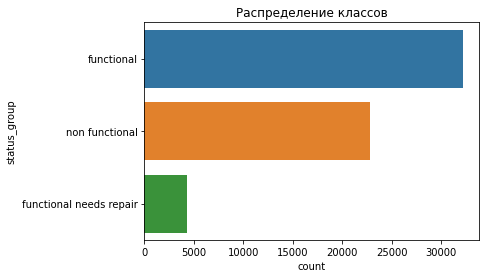

In [8]:
sns.countplot(data=df_target, y='status_group').set_title('Распределение классов');

### Широта и долгота

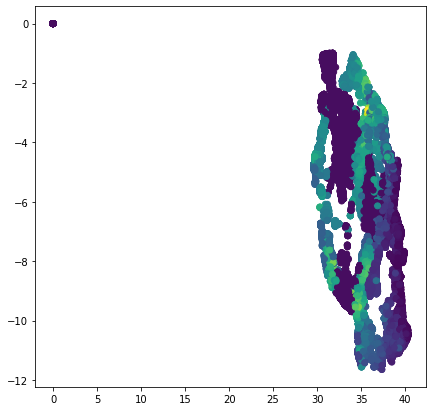

In [9]:
plt.figure(figsize=(7, 7))
plt.scatter(df_all.longitude, df_all.latitude, c=df_all.gps_height)
plt.show()

In [10]:
# обновим координаты колонок с водой, улитевших за пределы карты, средними кординатами остальных колонок принадлежащих этой же деревни

df_all['longitude'][df_all['longitude'] < 1] = np.NaN
df_all['latitude'][df_all['longitude'] < 1] = np.NaN

for geo in ['subvillage','lga']:
  mask = df_all['longitude'].isna()
  average_coordinates = df_all[~mask].groupby(geo)[['longitude', 'latitude']].mean()
  df_all.longitude[mask] = df_all[mask][geo].map(average_coordinates['longitude'])
  df_all.latitude[mask] = df_all[mask][geo].map(average_coordinates['latitude'])

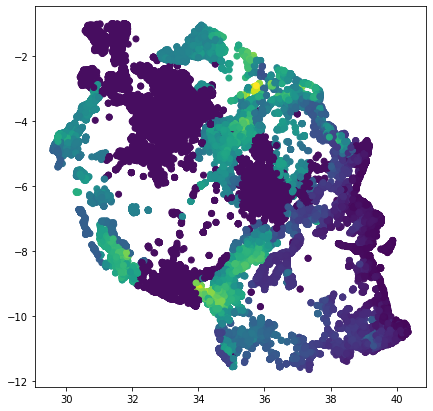

In [11]:
plt.figure(figsize=(7, 7))
plt.scatter(df_all.longitude, df_all.latitude, c=df_all.gps_height)
plt.show()

### gps_height

In [12]:

df_hist = pd.DataFrame({'Before':df_all['gps_height']})

In [13]:
# заполним пропуски о высоте местности с помощью соседних точек

df_all['gps_height'][df_all['gps_height'] == 0] = np.NaN
df_all.update(fill_values_with_neighbours(df_all, no_cat_features=['gps_height']))

In [14]:
df_hist['After'] = df_all['gps_height']

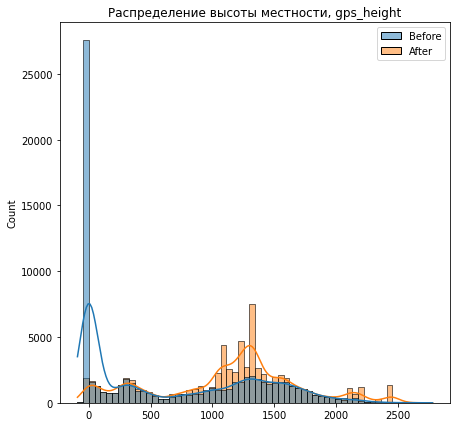

In [15]:
plt.figure(figsize=(7, 7))
sns.histplot(data=df_hist, kde=True).set_title('Распределение высоты местности, gps_height');

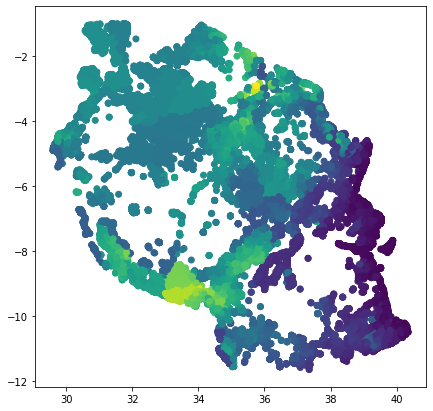

In [16]:
plt.figure(figsize=(7, 7))
plt.scatter(df_all.longitude, df_all.latitude, c=df_all.gps_height)
plt.show()

### Размер популяции

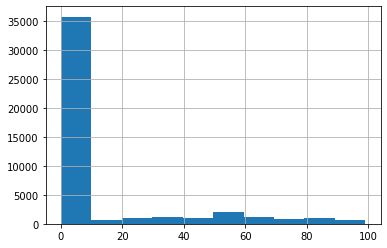

In [17]:
df_all['population'][df_all['population']<100].hist();

In [18]:
df_all['population'][df_all['population']<2] = np.NaN

In [19]:
df_all.update(
    fill_values_with_neighbours(
        df_all,
        no_cat_features=['population']
    )
)

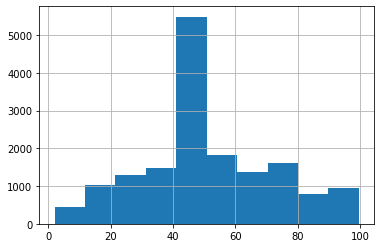

In [20]:
df_all['population'][df_all['population']<100].hist();

### Преоброзование дат

In [21]:
# разобьем дату на годы, месяцы и дни

df_all['date_recorded'] = pd.to_datetime(df_all['date_recorded'])
df_all['year_recorded'] = df_all['date_recorded'].dt.year
df_all['month_recorded'] = df_all['date_recorded'].dt.month
df_all['days_recorded'] = (df_all.date_recorded - df_all.date_recorded.min()).dt.days

In [22]:
# вычислим время жизни в днях с момента создания колонки.

t = pd.to_datetime(df_all['construction_year'][df_all['construction_year']!=0], format='%Y')
df_all['lifetime_days'] = (df_all['date_recorded'].loc[t.index] - t).dt.days
df_all['lifetime_days'].fillna(-999, inplace=True)
df_all['construction_year_is_null'] = df_all['construction_year'] == 0

### Не придумал названия

In [23]:
# добавим новые признаки сигнализирующие о пропуске значения в признаке

for feature in ['funder', 'installer', 'scheme_name', 'scheme_management', 'public_meeting', 'permit', 'subvillage']:
  df_all[f'{feature}_is_null'] = df_all[feature].isna()

In [24]:
# заполним пропуски в категориальных признаках по ближайшим соседям
df_all.update(
    fill_values_with_neighbours(
        df_all,
        cat_features=['funder', 'installer', 'scheme_name', 'scheme_management', 'public_meeting', 'permit', 'subvillage']
    )
)

In [25]:
df_all['amount_tsh_is_null'] = df_all['amount_tsh'] == 0.0

In [26]:
df_all.drop(columns=['date_recorded','recorded_by'], inplace=True)

In [27]:
cat_features = [
      'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
      'lga', 'ward', 'public_meeting', 'scheme_management',
      'scheme_name', 'permit', 'extraction_type',
      'extraction_type_group', 'extraction_type_class', 'management',
      'management_group', 'payment', 'payment_type', 'water_quality',
      'quality_group', 'quantity', 'quantity_group', 'source',
      'source_type', 'source_class', 'waterpoint_type',
      'waterpoint_type_group', 'region_code', 'district_code'
]

liner_features = [
      'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
      'population', 'construction_year',
      'year_recorded',
      'month_recorded', 'days_recorded', 'lifetime_days'
]

bool_features = [
      'funder_is_null', 'construction_year_is_null',
      'installer_is_null', 'scheme_name_is_null',
      'scheme_management_is_null', 'public_meeting_is_null',
      'permit_is_null', 'subvillage_is_null','amount_tsh_is_null'
]

geo_features = ['longitude', 'latitude', 'gps_height']


In [28]:
df_all.dtypes.value_counts()

object     28
bool       10
int64       7
float64     6
dtype: int64

# Кластеризация

## Предобработка признаков

In [29]:
df_cluster = df_all[df_all['is_train']].drop(columns=['is_train'])
df_cluster.update(df_cluster.select_dtypes(include='bool').astype('int'))


In [30]:
le_encoder = OrdinalEncoder(cols=['status_group'])
df_cluster_target = le_encoder.fit_transform(df_target)

In [31]:
encoder = CatBoostEncoder(cols=cat_features)
df_cluster = encoder.fit_transform(df_cluster, y=df_cluster_target.status_group.loc[df_cluster.index])

In [32]:
scaler = StandardScaler()
df_cluster.update(
    pd.DataFrame(
        scaler.fit_transform(df_cluster[liner_features + cat_features]),
        columns=df_cluster[liner_features + cat_features].columns,
        index=df_cluster.index
      )
)


## KMeans

In [33]:
# подберем приемлемое колицество кластеров

nogeo_cluster_metrics = get_cluster_metircs(df_cluster.drop(columns=geo_features), max_clusters=20)


In [34]:
geo_cluster_metrics = get_cluster_metircs(df_cluster, max_clusters=20)

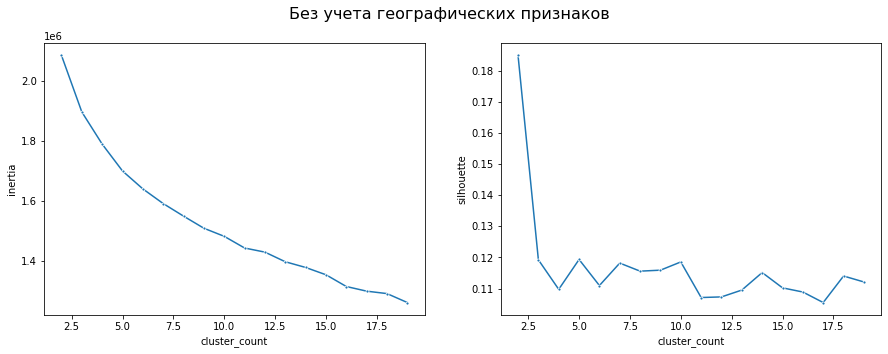

In [35]:
plot_cluster_metrics(nogeo_cluster_metrics, title='Без учета географических признаков')

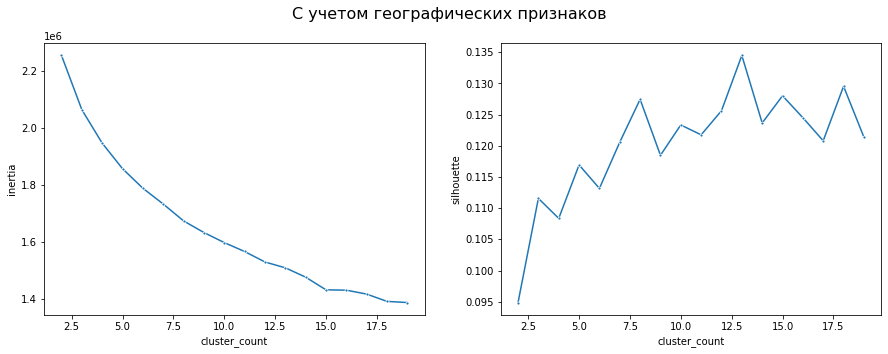

In [36]:
plot_cluster_metrics(geo_cluster_metrics, title='С учетом географических признаков')

In [37]:
nogeo_km = KMeans(n_clusters=7, n_jobs=2).fit(df_cluster.drop(columns=geo_features))
geo_km = KMeans(n_clusters=7, n_jobs=2).fit(df_cluster)

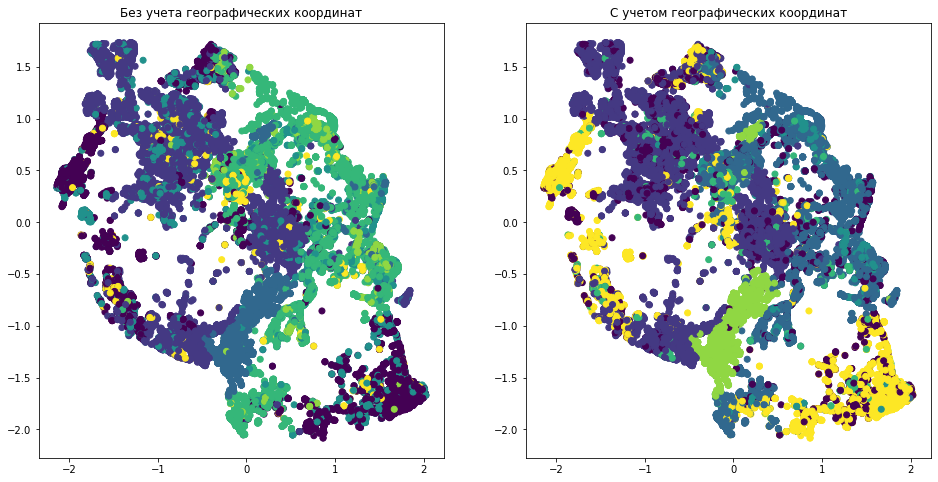

In [38]:
fig, ax = plt.subplots(1,2,figsize=(16, 8))

ax[0].scatter(df_cluster.longitude, df_cluster.latitude, c=nogeo_km.labels_)
ax[0].set_title('Без учета географических координат')
ax[1].scatter(df_cluster.longitude, df_cluster.latitude, c=geo_km.labels_)
ax[1].set_title('С учетом географических координат');

## Добавление признаков

In [39]:
df_val = df_all.loc[~df_all['is_train']].drop(columns=['is_train'])

In [40]:
# Попробуем добавить метку кластера как дополнительный признак
df_train = df_all.loc[df_cluster.index].drop(columns=['is_train'])
df_train['geo_label'] = geo_km.predict(df_cluster)
df_train['nogeo_label'] = nogeo_km.predict(df_cluster.drop(columns=geo_features))

In [41]:
df_val_tmp = df_all[~df_all['is_train']].copy().drop(columns=['is_train'])
df_val_tmp.update(df_val_tmp[bool_features].astype('int'))
df_val_tmp = encoder.transform(df_val_tmp)

In [42]:
df_val_tmp.update(
    pd.DataFrame(
        scaler.transform(df_val_tmp[liner_features + cat_features]),
        columns=df_val_tmp[liner_features + cat_features].columns,
        index=df_val_tmp.index
      )
)
df_val['geo_label'] = geo_km.predict(df_val_tmp.loc[df_val.index])
df_val['nogeo_label'] = nogeo_km.predict(df_val_tmp.drop(columns=geo_features).loc[df_val.index])

In [43]:
df_val['geo_label'] = geo_km.predict(df_val_tmp.loc[df_val.index])
df_val['nogeo_label'] = nogeo_km.predict(df_val_tmp.drop(columns=geo_features).loc[df_val.index])

# Классификация

## Предобработка признаков

In [44]:
df_train.update(
    df_train[bool_features].astype('int')
)

In [45]:
df_y = le_encoder.transform(df_target.loc[df_train.index])

In [46]:
x_train, x_test, y_train, y_test = train_test_split(
    df_train,
    df_y,
    random_state=32,
    stratify=df_y
)

In [47]:
encoder = CatBoostEncoder(cols=cat_features+['geo_label', 'nogeo_label'])
encoder.fit(x_train, y_train)

CatBoostEncoder(a=1,
                cols=['funder', 'installer', 'wpt_name', 'basin', 'subvillage',
                      'region', 'lga', 'ward', 'public_meeting',
                      'scheme_management', 'scheme_name', 'permit',
                      'extraction_type', 'extraction_type_group',
                      'extraction_type_class', 'management', 'management_group',
                      'payment', 'payment_type', 'water_quality',
                      'quality_group', 'quantity', 'quantity_group', 'source',
                      'source_type', 'source_class', 'waterpoint_type',
                      'waterpoint_type_group', 'region_code', 'district_code', ...],
                drop_invariant=False, handle_missing='value',
                handle_unknown='value', random_state=None, return_df=True,
                sigma=None, verbose=0)

In [48]:
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

In [49]:
# стандартиризуем все не булевы переменные

scaler_features = liner_features + ['geo_label', 'nogeo_label'] + cat_features
scaler = StandardScaler()
x_train.update(
    pd.DataFrame(
        scaler.fit_transform(x_train[scaler_features]),
        columns=x_train[scaler_features].columns,
        index=x_train.index
    )
)

x_test.update(
    pd.DataFrame(
        scaler.transform(x_test[scaler_features]),
        columns=x_test[scaler_features].columns,
        index=x_test.index
    )    
)

## LogisticRegression

In [50]:
liner_model = LogisticRegression()
liner_model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
liner_pred = liner_model.predict(x_test)

In [52]:
print(classification_report(y_test, liner_pred))

              precision    recall  f1-score   support

           1       0.75      0.84      0.79      8065
           2       0.72      0.69      0.70      5706
           3       0.37      0.15      0.21      1079

    accuracy                           0.73     14850
   macro avg       0.61      0.56      0.57     14850
weighted avg       0.71      0.73      0.72     14850



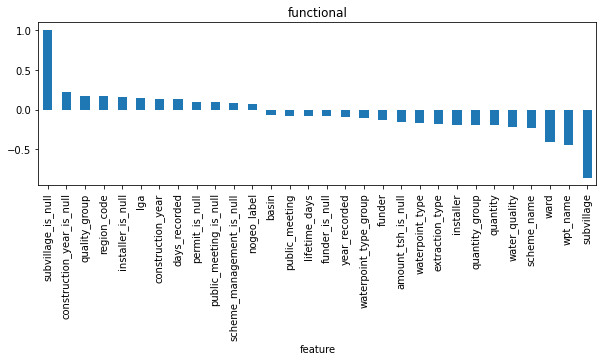

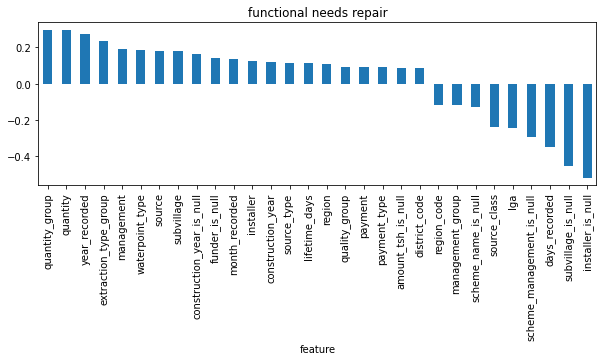

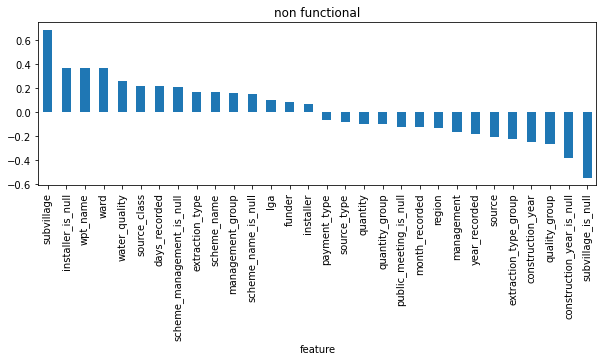

In [53]:
# Важность признаков по классам
for i, title in enumerate(['functional', 'functional needs repair','non functional']):
  plt.figure(figsize=(10, 3))
  plot_feature_importance(x_train.columns.values, liner_model.coef_[i,:], top=30, title=title)
  plt.show()


## LGBMClassifier

In [54]:
# подбор параметров
params = {
    'max_depth': hp.choice('max_depth', range(1, 3)),
    'n_estimators': hp.choice('n_estimators', range(50, 150)),
    'reg_alpha': hp.uniform('reg_alpha', 0., 2),
    'reg_lambda': hp.uniform('reg_lambda', 0., 2),
    'num_leaves': hp.choice('num_leaves', range(2, 100)),
    'min_child_samples': hp.choice('min_child_samples', range(1, 100))
}
lgbm_best_params = search_optimal_params(LGBMClassifier( ), params, x_train, y_train, lambda *x: -1*f1_score(*x, average='weighted'))
# lgbm_best_params = search_optimal_params(LGBMClassifier(n_jobs=2 ), params, x_train, y_train, accuracy_score)
print(f"Лучшие гипер параметры: {lgbm_best_params}")

100%|██████████| 150/150 [04:43<00:00,  1.89s/it, best loss: -0.7968033397990648]
Лучшие гипер параметры: {'max_depth': 1, 'min_child_samples': 95, 'n_estimators': 99, 'num_leaves': 48, 'reg_alpha': 0.8397989134013288, 'reg_lambda': 0.09174654341984739}


In [55]:
lgbm_model = LGBMClassifier(**lgbm_best_params)
lgbm_model.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=1,
               min_child_samples=95, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=99, n_jobs=-1, num_leaves=48, objective=None,
               random_state=None, reg_alpha=0.8397989134013288,
               reg_lambda=0.09174654341984739, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [56]:
lgbm_pred = lgbm_model.predict(x_test)

In [57]:
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           1       0.72      0.87      0.79      8065
           2       0.75      0.63      0.68      5706
           3       0.47      0.12      0.20      1079

    accuracy                           0.73     14850
   macro avg       0.65      0.54      0.56     14850
weighted avg       0.71      0.73      0.71     14850



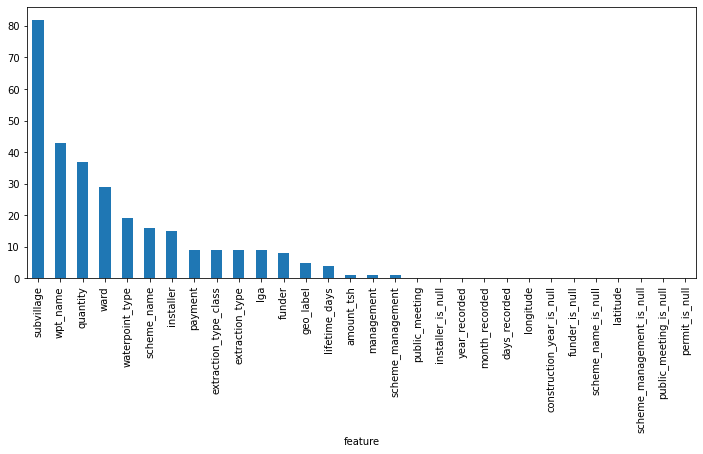

In [58]:
# посмотрим самые важные признаки
plt.figure(figsize=(12,5))
plot_feature_importance(x_train.columns.values, lgbm_model.feature_importances_, top=30)

## Сформируем данные на отправку

In [59]:
x_val = encoder.transform(df_val)
x_val.update(
    x_val[bool_features].astype('int')
)
x_val.update(
    pd.DataFrame(
        scaler.transform(x_val[scaler_features]),
        columns=x_val[scaler_features].columns,
        index=x_val.index
    )
)

In [60]:
liner_pred = liner_model.predict(x_val)
lgbm_pred = lgbm_model.predict(x_val)

liner_pred = pd.DataFrame(
    {'status_group': liner_pred},
    index=x_val.index
)

lgbm_pred = pd.DataFrame(
    {'status_group': lgbm_pred},
    index=x_val.index
)

liner_pred = le_encoder.inverse_transform(liner_pred)
lgbm_pred = le_encoder.inverse_transform(lgbm_pred)

In [61]:
save_submission(liner_pred, 'liner')
save_submission(lgbm_pred, 'lgbm')